# Linking elements together

As explained in the Data Structure chapter, `momepy` relies on links between different morphological elements. Each element has an index, and each of the small-scale elements also needs to know the index of the relevant higher-scale element. The case of block index is explained in the previous chapter, `momepy.generate_blocks` generates it together with blocks gdf.

## Getting the index of the street network

This notebook will explore how to link street network, both nodes and edges, to buildings and tessellation.

### Edges

For linking street network edges to buildings (or tessellation or other elements), `momepy` offers `momepy.get_nearest_street`. It simply returns a `Series` of indices of nearest streets for analysed gdf.

In [1]:
import geopandas as gpd
import momepy

For illustration, we can use `bubenec` dataset embedded in `momepy`.

In [2]:
path = momepy.datasets.get_path("bubenec")
buildings = gpd.read_file(path, layer="buildings")
streets = gpd.read_file(path, layer="streets")
tessellation = gpd.read_file(path, layer="tessellation")

Then we can link it to buildings. The only argument we might want to look at is `max_distance`, which is a maximum distance within which to query for nearest street. Note that for large areas, it is advised to set a limit to avoid long processing times.

In [3]:
buildings["street_index"] = momepy.get_nearest_street(buildings, streets)

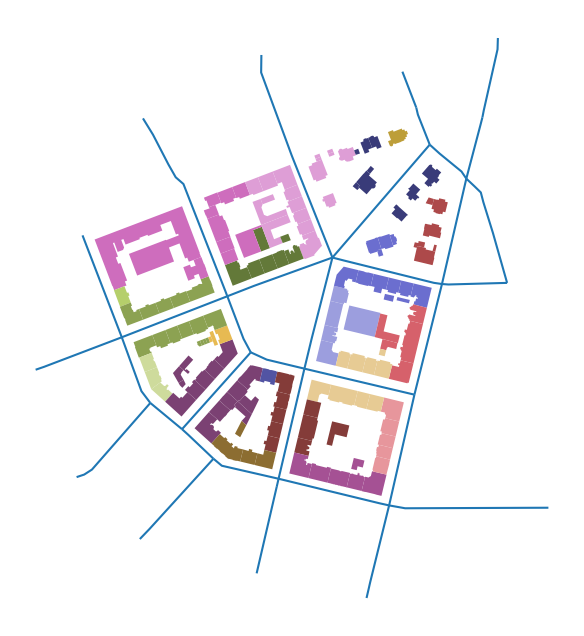

In [4]:
ax = buildings.plot(
    column="street_index", categorical=True, cmap="tab20b", figsize=(8, 8)
)
streets.plot(ax=ax)
ax.set_axis_off()

Note: colormap does not have enough colours, that is why everything on the top-left looks the same. It is not.

### Nodes

The situation with nodes is slightly more complicated as you usually don't have or even need nodes. However, `momepy` includes some functions which are calculated on nodes (mostly in `graph` module). For that reason, we will pretend that we follow the usual workflow:

1. Street network `GeoDataFrame` (edges only)
2. networkx `Graph`
3. Street network - edges and nodes as separate `GeoDataFrames`.

In [5]:
graph = momepy.gdf_to_nx(streets)

Some [graph-based analysis](../graph/graph.rst) happens here.

In [6]:
nodes, edges = momepy.nx_to_gdf(graph)

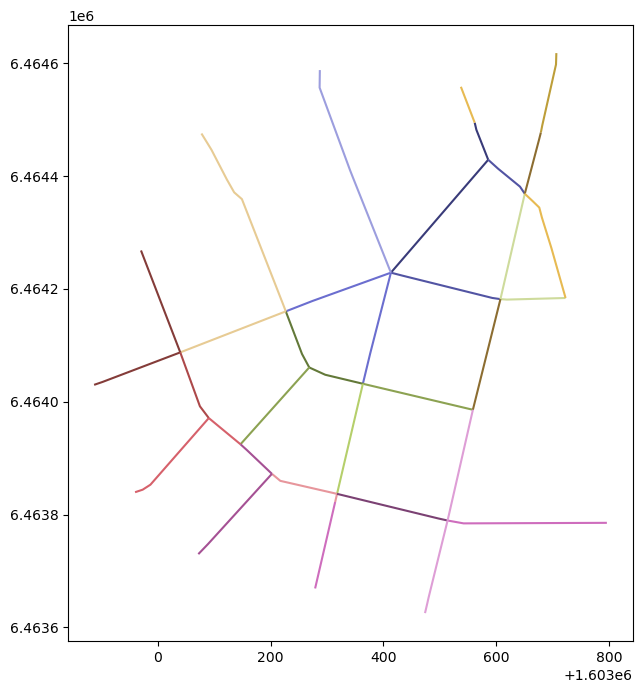

In [7]:
edges.plot(
    column=edges.index.values, categorical=True, cmap="tab20b", figsize=(8, 8)
)
nodes.plot(ax=ax, zorder=2)
ax.set_axis_off()

For attaching node ID to buildings, we will need both, nodes and edges. Given the index `edges` created from the graph likely do not match the `streets`, determine which edge building belongs to using `momepy.get_nearest_street` and then find out which end of the edge is the closer one.

In [15]:
buildings["edge_index"] = momepy.get_nearest_street(buildings, edges)

The node index is also inlcuded in `edges` as well, denoting each end of edge. (Length of the edge is also present as it was necessary to keep as an attribute for the graph.)

In [8]:
edges.head()

,geometry,mm_len,node_start,node_end
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",264.103950,0,1
1,"LINESTRING (1603561.74 6464494.467, 1603564.63...",70.020202,0,8
2,"LINESTRING (1603585.64 6464428.774, 1603603.09...",88.924305,0,6
3,"LINESTRING (1603607.303 6464181.853, 1603592.8...",199.746503,1,4
4,"LINESTRING (1603363.558 6464031.885, 1603376.5...",203.014090,1,3


We can now use `momepy.get_nearest_node` to attach nodes. Keep in mind that this is not just a nearest neighbor join, each nearest node is ensured to be on one end of the nearest edge.

In [12]:
buildings["node_index"] = momepy.get_nearest_node(
    buildings, nodes, edges, buildings["edge_index"]
)

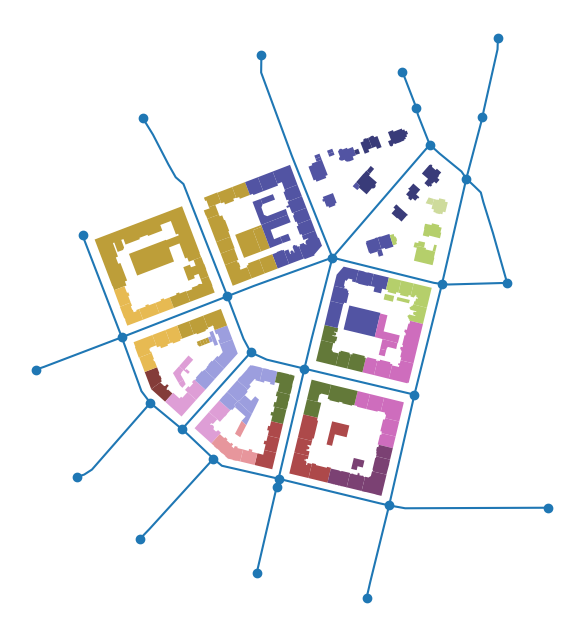

In [10]:
ax = buildings.plot(
    column="node_index", categorical=True, cmap="tab20b", figsize=(8, 8)
)
nodes.plot(ax=ax, zorder=2)
edges.plot(ax=ax, zorder=1)
ax.set_axis_off()

### Transfer IDs to tessellation
All IDs are now stored in buildings gdf. We can copy them to tessellation directly as both share the same index.

In [13]:
tessellation[["edge_index", "node_index"]] = buildings[
    ["edge_index", "node_index"]
]
tessellation.head()

,uID,geometry,edge_index,node_index
0,1.0,"POLYGON ((1603578.489 6464344.527, 1603577.04 ...",0.0,0.0
1,2.0,"POLYGON ((1603067.112 6464177.926, 1603054.848...",20.0,9.0
2,3.0,"POLYGON ((1602978.618 6464156.859, 1603006.384...",22.0,11.0
3,4.0,"POLYGON ((1603056.595 6464093.903, 1603011.539...",19.0,11.0
4,5.0,"POLYGON ((1603110.459 6464114.367, 1603109.099...",19.0,11.0


Now we should be able to link all elements together as needed for all types of morphometric analysis in `momepy`.